In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler

from transformers import BertTokenizer, BertForSequenceClassification,get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader


from sklearn.utils.class_weight import compute_class_weight
import numpy as np

from sklearn.metrics import classification_report

from tqdm import tqdm



In [ ]:
import spacy
import re



In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# Load SpaCy model (English only)
nlp = spacy.load("en_core_web_sm")

def clean_email(text):
    """
    Clean email text by removing subject line and normalizing whitespace.
    """
    # Ensure UTF-8 encoding
    try:
        text = text.encode("utf-8").decode("utf-8")
    except UnicodeDecodeError:
        text = text.encode("latin-1").decode("utf-8", errors="ignore")
    # Normalize whitespace
    text = " ".join(text.split())
    # Remove subject line
    if "Subject:" in text:
        # Try splitting on double newline
        parts = text.split("\n\n", 1)
        if len(parts) > 1:
            text = parts[1]
        else:
            # Fallback: search for salutations
            salutations = ["Sehr geehrte", "Dear ", "Hallo "]
            for sal in salutations:
                if sal in text:
                    #text = text.index(sal):]
                    text = text[text.index(sal):]

                    break
            else:
                # Take after "Subject:"
                text = text.split("Subject:", 1)[1].strip()
    return text


def mask_pii(email_text):
    """
    Mask PII in email text using SpaCy for dates and regex for other entities.
    Args:
        email_text (str): Input email text
    Returns:
        tuple: (masked_email, list_of_entities)
    """
    # Clean email first
    cleaned_text = clean_email(email_text)
    entities = []
    masked_text = cleaned_text

    # Process with SpaCy for entity recognition
    doc = nlp(cleaned_text)

    # Extract and mask dates first
    date_entities = []
    for ent in doc.ents:
        if ent.label_ == "DATE" and not re.match(r"\d{4}[- ]\d{4}[- ]\d{4}[- ]\d{4}|\d{4}\s\d{4}\s\d{4}", ent.text):
            if re.search(r"\d{1,2}[./]\d{1,2}[./]\d{2,4}|\d{1,2}[- ]\w+[- ]\d{2,4}", ent.text):
                date_entities.append({
                    "text": ent.text,
                    "start": ent.start_char,
                    "end": ent.end_char,
                    "type": "dob"
                })

    for date_entity in sorted(date_entities, key=lambda x: x["start"], reverse=True):
        entity_value = date_entity["text"]
        start, end = date_entity["start"], date_entity["end"]
        entities.append({
            "position": [start, end],
            "classification": "dob",
            "entity": entity_value
        })
        masked_text = masked_text[:start] + "[dob]" + masked_text[end:]

    # Enhanced regex patterns for PII with context capturing
    patterns = [
        # Full name patterns with context capturing
        (r"((?:My name is|I am|I'm|name[: ]+|This is|My full name is) )([A-Z][a-z]+(?: [A-Z][a-z]+)+)", "[full_name]", "full_name", True),
        (r"(?:^|\. |, )([A-Z][a-z]+ [A-Z][a-z]+)(?=$|\. )", "[full_name]", "full_name", False),

        # Email patterns - modified to more precisely capture just the email with context
        (r"((?:email(?:[ ]?(?:me|is|at))?:? |reach me at |contact(?:[ ]?(?:me|at))?:? ))(\S+@\S+\.\S+)(?=[,. ]|$)", "[email]", "email", True),
        (r"(\S+@\S+\.\S+)(?=[,. ]|$)", "[email]", "email", False),

        # Phone number patterns (international format support)
        (r"((?:phone(?:[ ]?(?:is|at|number))?:? |call me at ))?\b((?:\+\d{1,3}[- ]?)?\(?\d{3}\)?[- ]?\d{3}[- ]?\d{4})\b", "[phone_number]", "phone_number", True),

        # Identification numbers with potential context
        (r"((?:Aadhar(?:[ ]?(?:is|number))?:? ))?(\b\d{4}\s\d{4}\s\d{4}\b)", "[aadhar_num]", "aadhar_num", True),
        (r"((?:card(?:[ ]?(?:is|number))?:? ))?(\b\d{4}[- ]?\d{4}[- ]?\d{4}[- ]?\d{4}\b)", "[credit_debit_no]", "credit_debit_no", True),

        # Security codes with context
        (r"((?:CVV:? ))(\d{3})\b", "[cvv_no]", "cvv_no", True),
        (r"\b(\d{3})\b", "[cvv_no]", "cvv_no", False),

        # Expiry dates with context
        (r"((?:expiry:? ))(\d{2}/\d{2})\b", "[expiry_no]", "expiry_no", True),
        (r"\b(\d{2}/\d{2})\b", "[expiry_no]", "expiry_no", False)
    ]

    # Apply regex patterns sequentially
    for pattern, replacement, entity_type, has_context in patterns:
        matches = list(re.finditer(pattern, masked_text, re.IGNORECASE))
        for match in sorted(matches, key=lambda x: x.start(), reverse=True):
            start, end = match.start(), match.end()

            try:
                context = match.group(1) if has_context else ""
                entity_value = match.group(2) if has_context else match.group(1)
            except IndexError:
                continue  # Skip if groups are not properly matched

            context_start = start
            context_end = start + len(context) if context else start
            entity_start = context_end if context else start
            entity_end = end

            if any(entity_start >= e["position"][0] and entity_end <= e["position"][1] for e in entities):
                continue

            if re.search(r"\[\w+\]", masked_text[entity_start:entity_end]):
                continue

            entities.append({
                "position": [entity_start, entity_end],
                "classification": entity_type,
                "entity": entity_value,
                "context": context,
                "context_position": [context_start, context_end]
            })

            if context:
                masked_text = masked_text[:context_end] + replacement + masked_text[entity_end:]
            else:
                masked_text = masked_text[:entity_start] + replacement + masked_text[entity_end:]

    return masked_text, entities

# def demask_email(masked_email, entities):
#     """
#     Restore original email from masked email using stored entities while preserving context phrases.

#     Args:
#         masked_email (str): The masked email text with placeholders
#         entities (list): List of entity dictionaries with position, classification, and entity

#     Returns:
#         str: Email with original entities restored while preserving context phrases
#     """
#     # Sort entities by position (ascending) for proper replacement
#     sorted_entities = sorted(entities, key=lambda x: x["position"][0])

#     # Create a result by working from the end to the beginning to avoid offset issues
#     demasked_email = masked_email

#     # Create a mapping of placeholders to their entities
#     placeholder_map = {}
#     for entity in sorted_entities:
#         classification = entity["classification"]
#         placeholder = f"[{classification}]"

#         # Group entities by classification
#         if placeholder not in placeholder_map:
#             placeholder_map[placeholder] = []

#         # Include context information if available
#         entity_info = {
#             "entity": entity["entity"],
#             "context": entity.get("context", "")
#         }

#         placeholder_map[placeholder].append(entity_info)

#     # Replace placeholders with original values while preserving context
#     for placeholder, entity_infos in placeholder_map.items():
#         # Count how many instances of this placeholder exist
#         placeholder_count = demasked_email.count(placeholder)

#         # If we have fewer entities than placeholders, reuse the last entity
#         if placeholder_count > len(entity_infos):
#             entity_infos += [entity_infos[-1]] * (placeholder_count - len(entity_infos))

#         # Replace each instance of the placeholder
#         for i in range(min(placeholder_count, len(entity_infos))):
#             entity_info = entity_infos[i]
#             entity_value = entity_info["entity"]

#             # The key change: we don't replace context that's already in the text
#             # Instead, we just replace the placeholder with the entity value
#             demasked_email = demasked_email.replace(placeholder, entity_value, 1)

#     return demasked_email

In [5]:
df = pd.read_csv("emails_type.csv")  # Columns: 'email', 'label'
df.dropna(inplace=True)


In [6]:
# Preprocess: mask and clean emails
df["masked_cleaned_email"] = df["email"].apply(lambda x: clean_email(mask_pii(x)[0]))

In [7]:
# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["type"])

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df["masked_cleaned_email"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

In [9]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [10]:
# Tokenizer and model
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(df["label"].unique()),
    problem_type="single_label_classification"
)

# Custom weighted loss function
model.loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Move model to device (GPU or CPU)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [11]:
# Dataset class
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [12]:
# DataLoaders
train_dataset = EmailDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = EmailDataset(X_test.tolist(), y_test.tolist(), tokenizer)

# Calculate sampling weights
class_sample_counts = np.bincount(y_train)
samples_weight = [1.0 / class_sample_counts[label] for label in y_train]
sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [13]:
# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


In [14]:
# Training loop
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = model.loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

Epoch 1


Epoch 1: 100%|██████████| 1200/1200 [14:10<00:00,  1.41it/s, loss=0.34]


Epoch 2


Epoch 2: 100%|██████████| 1200/1200 [14:16<00:00,  1.40it/s, loss=0.283]


Epoch 3


Epoch 3: 100%|██████████| 1200/1200 [14:15<00:00,  1.40it/s, loss=0.294]


Epoch 4


Epoch 4: 100%|██████████| 1200/1200 [14:16<00:00,  1.40it/s, loss=0.141]


Epoch 5


Epoch 5: 100%|██████████| 1200/1200 [14:16<00:00,  1.40it/s, loss=0.258]


In [15]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

100%|██████████| 300/300 [01:07<00:00,  4.43it/s]


Classification Report:
              precision    recall  f1-score   support

      Change       0.90      0.94      0.92       504
    Incident       0.78      0.72      0.75      1917
     Problem       0.53      0.61      0.57      1007
     Request       0.94      0.94      0.94      1372

    accuracy                           0.78      4800
   macro avg       0.79      0.80      0.79      4800
weighted avg       0.79      0.78      0.78      4800



<Figure size 800x600 with 0 Axes>

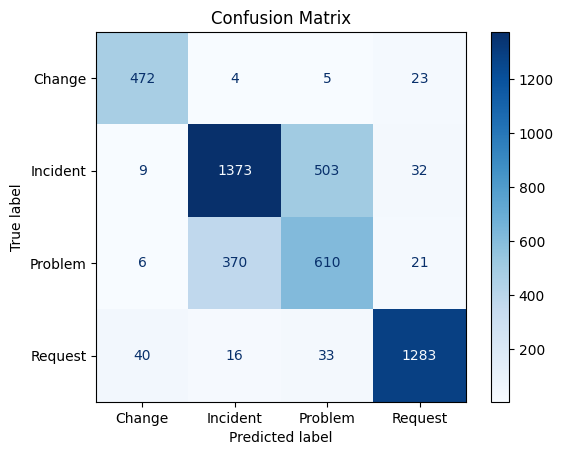

In [16]:


# Make sure all_preds and all_labels are lists or numpy arrays
cm = confusion_matrix(all_labels, all_preds)

# Optional: Display labels using your encoder if available
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot it
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d')  # 'd' = integer formatting
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [17]:
# Save model and tokenizer
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")


('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.txt',
 'saved_model/added_tokens.json')

In [18]:
!zip -r saved_model.zip saved_model
from google.colab import files
files.download("saved_model.zip")


  adding: saved_model/ (stored 0%)
  adding: saved_model/tokenizer_config.json (deflated 75%)
  adding: saved_model/vocab.txt (deflated 45%)
  adding: saved_model/special_tokens_map.json (deflated 42%)
  adding: saved_model/model.safetensors (deflated 7%)
  adding: saved_model/config.json (deflated 56%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>